# Compress momentum dependence at the lowest frequency

In [58]:
using Revise
using PyPlot
using LaTeXStrings
using PyCall

using LinearAlgebra
using SparseIR
using MultiScales

newaxis = [CartesianIndex()]

1-element Vector{CartesianIndex{0}}:
 CartesianIndex()

In [59]:
rcParams = PyDict(matplotlib["rcParams"])
rcParams["font.size"] = 18
rcParams["text.usetex"] = true
rcParams["font.family"] = "serif"
rcParams["font.serif"] = ["Computer Modern Roman"]

1-element Vector{String}:
 "Computer Modern Roman"

In [60]:
BLAS.set_num_threads(16)

In [61]:
println(Threads.nthreads())

1


In [62]:
using ITensors
ITensors.disable_warn_order()
println(ITensors.blas_get_num_threads())

16


In [63]:
ek(k) = 2*cos(k)

ek (generic function with 1 method)

In [64]:
# N = 16 is expensive, requiring more than 1GB. Try N = 10 for a quick check.
N = 16
half_N = N ÷ 2
nk = 2^N
kmesh = LinRange(0, 2π, nk)
@show 2^half_N

2 ^ half_N = 256


256

In [65]:
sites_all = []
M_all = []
g_all = []
s_all = []
betas = [10.0, 100.0, 1000.0]
target_link = 3

for beta in betas
    wmax = 10.0

    basis = FiniteTempBasis(Fermionic(), beta, wmax, 1e-10)
    smpl = MatsubaraSampling(basis)

    v = smpl.sampling_points
    iv = SparseIR.valueim.(v, beta)
    nw = length(v)

    giv0 = 1 ./ (iv[:,newaxis] .- ek.(kmesh)[newaxis,:])

    sitew = Index(nw, "w")
    sitesk = [Index(2, "Qubit,k=$k") for k in 1:N]
    tensor = ITensor(reshape(giv0, nw, repeat([2,], N)...), [sitew, reverse(sitesk)...])

    sites = [sitew, sitesk...]

    u, s, vt = svd(tensor, sites[1:target_link])
    s_ = Vector(diag(s))

    cutoff = 1E-8
    maxdim = 20000
    M = MPS(tensor, sites; cutoff=cutoff, maxdim=maxdim)

    push!(g_all, giv0)
    push!(sites_all, sites)
    push!(M_all, M)
    push!(s_all, s_)
end

In [75]:
[dim(sites[1]) for sites in sites_all]

3-element Vector{Int64}:
 30
 52
 74

In [66]:
sites = sites_all[end]
tensor_reconst = Array(reduce(*, M_all[end]), sites[1], reverse(sites[2:end]))
;

In [67]:
tensor_reconst = reshape(tensor_reconst, dim(sites[1]), nk);

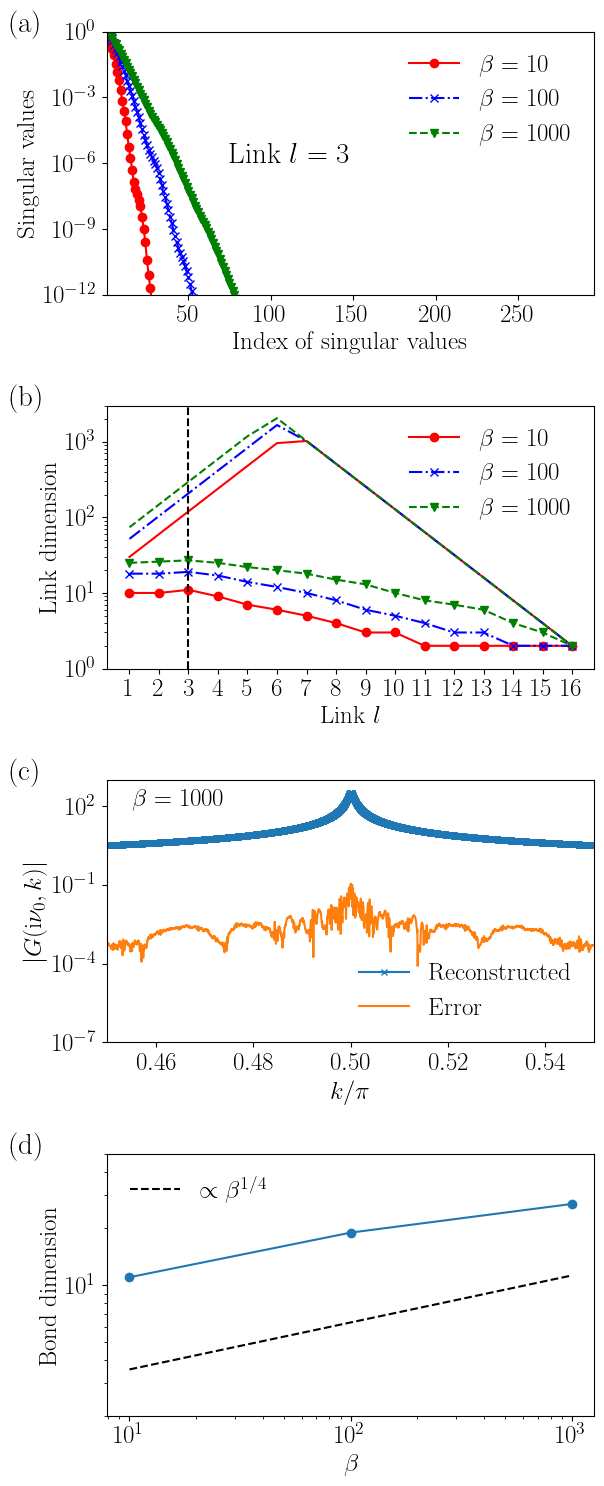

y = [11, 19, 27]


In [73]:
nc = 4
#fig = figure(figsize=(6.4, nc*4.8))
fig = figure(figsize=(6.4, nc*3.8))
colors = ["r", "b", "g"]
markers = ["o", "x", "v"]
ls = ["-", "-.", "--"]

subplot(nc, 1, 1)
annotate("(a)", xycoords="axes fraction", xy=(-0.2,1.0), fontsize=21)
annotate("Link " * L"l=%$(target_link)", xycoords="axes fraction", xy=(0.25,0.5), fontsize=21)
for (idx, beta) in enumerate(betas)
    s_ = s_all[idx]
    x = 1:length(s_)
    semilogy(x, s_ ./ s_[1], color=colors[idx], ls=ls[idx], label=L"\beta=%$(Int(beta))", marker=markers[idx])
    xlim([1, length(s_)])
end
legend(frameon=false)
ylim([1e-12, 1])
xlabel("Index of singular values")
ylabel("Singular values")

subplot(nc, 1, 2)
annotate("(b)", xycoords="axes fraction", xy=(-0.2,1.0), fontsize=21)
for (idx, beta) in enumerate(betas)
    sites = sites_all[idx]
    M = M_all[idx]
    maxlinkdims_ = MultiScales.maxlinkdims(sites)
    links = collect(1:length(maxlinkdims_))
    semilogy(links, maxlinkdims_, ls=ls[idx], color=colors[idx])
    semilogy(links, MultiScales.linkdims(M), color=colors[idx], ls=ls[idx], label=L"\beta=%$(Int(beta))", marker=markers[idx])
end
axvline(target_link, ls="--", color="k")
xticks(1:length(sites)-1)
legend(frameon=false)
xlabel("Link " * L"l")
ylabel("Link dimension")
ylim([1,3e+3])

subplot(nc, 1, 3)
annotate("(c)", xycoords="axes fraction", xy=(-0.2,1.0), fontsize=21)
annotate(L"\beta=%$(Int(betas[end]))", xycoords="axes fraction", xy=(0.05, 0.9))

nw = size(tensor_reconst, 1)
y = tensor_reconst[nw÷2+1,:]
y2 = g_all[end][nw÷2+1,:]

x = kmesh / π
semilogy(x, abs.(y), marker="x", markersize=4, label="Reconstructed", ls="-")
semilogy(x, abs.(y-y2), label="Error")
xlabel(L"k/\pi")
ylabel(L"|G(\mathrm{i}\nu_0, k)|")
legend(frameon=false)
xlim([0.45, 0.55])
ylim([1e-7, 1e+3])
#title(L"\beta=%$(Int(betas[end]))")

subplot(nc, 1, 4)
annotate("(d)", xycoords="axes fraction", xy=(-0.2,1.0), fontsize=21)

y = [maximum(MultiScales.linkdims(M)) for M in M_all]
@show y
loglog(betas, y, marker="o")
loglog(betas, 2 .* betas .^ 0.25, label=L"\propto \beta^{1/4}", ls="--", color="k")
xlabel(L"\beta")
ylabel("Bond dimension")
ylim([2,50])
legend(frameon=false)

tight_layout()
savefig("1d_freqmomdep_N$N.pdf", bbox_inches="tight", transparent=true)
display(gcf())

close(fig)